# Trabalho avaliativo - Sistemas de controle II - 2023.2

**Leia com atenção as instruções abaixo**

*Informe na célula de código abaixo o seu número de matrícula:* 

***Não remova as aspas***

In [43]:
# Informe aqui sua matrícula
mat = '201733940007'

*Depois de informar os dados, execute o arquivo inteiro. Caso ocorra algum erro, peça ajuda ao professor*

*Resolva as questões abaixo, **justificando** todas as respostas. Utilize markdown para escrever texto e Python para fazer as contas. O trabalho é individual*

In [44]:
# 
# Não modifique esta célula! Você pode comprometer a sua avaliação.
from numpy.random import RandomState
from IPython.display import display, Math
from sympy import symbols, sin, cos, latex
from sympy import ImmutableMatrix as matriz
from numpy import arange

_nn = int(mat[0:4]+mat[-2:])
_rng = RandomState(_nn)
#_dig = arange(-9,10)
#_dig = _dig[_dig!=0]
#_n = _rng.randint(0,_dig.size,20)
_n = _rng.random(size=(4,)).round(3)
def G(): 
    s = symbols('s')
    c = .5+0.10*_n[0]
    d = .5+0.25*_n[1]
    a = .2+0.15*_n[2]
    b = 9+_n[3]
    b0 = (b*c**2*d).round(3)
    b1 = (a*b*c**2*d).round(3)
    G = (b1*s+b0)/((s+c)**2*(s+d))
    display(Math('G(s) = ' + latex(G)))

## 1.

*Considere o sistema:*

In [45]:
G()

<IPython.core.display.Math object>

1. *Faça uma análise de malha aberta: verifique estabilidade e características de resposta ao degrau unitário (25%). Opcional: analise o que aconteceria caso fosse utilizada realimentação proporcional (+10% extra)*

2. *Proponha especificações de desempenho em malha fechada com base na análise de malha aberta do item 1 (20%).*

3. *Projete um compensador de estados de ordem completa, de acordo com as especificações estabelecidas no item 2 e também forneça rejeição à distúrbios do tipo degrau. Justifique as escolhas de todos os pólos e apresente as funções de transferência do compensador ao final (35%).*

4. *Analise e simule o sistema em malha fechada. Plote e analise os sinais de saída e de controle (20%). Opcional: faça uma análise de resposta a uma perturbação (+10% extra)*

# QUESTÃO 1

In [46]:
import control as ct
import numpy as np
from matplotlib import pyplot as plt

# Expandindo o denominador
den = np.poly([-0.5927, -0.5927,-0.73025])
print("Denominador Expandido: ", den)
print()

Denominador Expandido:  [1.         1.91565    1.21693164 0.25653193]



Criando a Função de Transferência

In [47]:
num = np.array([0.589, 2.344])

GS = ct.tf(num, den)
print(GS)


         0.589 s + 2.344
----------------------------------
s^3 + 1.916 s^2 + 1.217 s + 0.2565



Verificando da Estabiblidade do sistema

In [48]:
ct.damp(GS);

_____Eigenvalue______ Damping___ Frequency_
   -0.7302                     1     0.7302
   -0.5927                     1     0.5927
   -0.5927                     1     0.5927


Os pólos da sistema se encontram no lado esquerdo do plano complexo, ou seja, o sistema é estável.

#### Aplicando um degrau unitário na entrada

Simulação do sistema em malha aberta

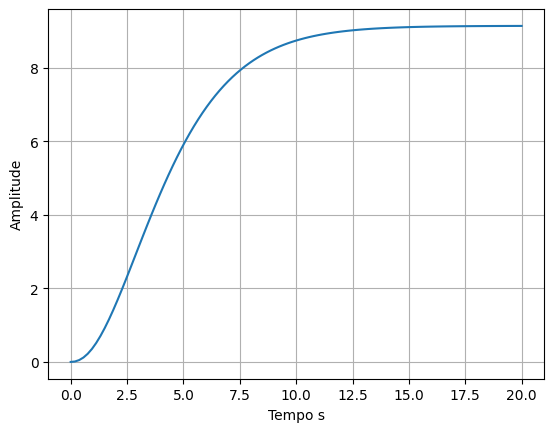

Dados da simulação


{'RiseTime': 6.710296620888371,
 'SettlingTime': nan,
 'SettlingMin': 8.253327969219521,
 'SettlingMax': 9.137264298758963,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 8.953584186051225,
 'PeakTime': 11.654725709964012,
 'SteadyStateValue': 9.137264298758963}

In [49]:
t, y = ct.step_response(GS, 20)
plt.plot(t, y)
plt.xlabel("Tempo s")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

print("Dados da simulação")
ct.step_info(GS)


O sistema em malha aberta se comporta de forma estável como foi observado anteriormente, além disso tem Sobresinal igual a zero.



### Realimentação com Controle Proporcional


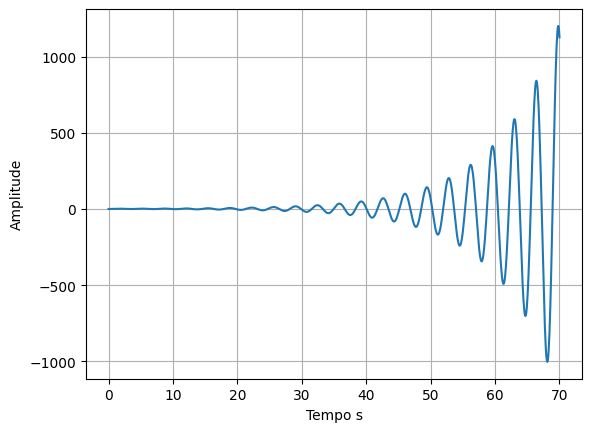

_____Eigenvalue______ Damping___ Frequency_
    -2.125                     1      2.125
    0.1048    +1.849j    -0.0566      1.852
    0.1048    -1.849j    -0.0566      1.852


In [50]:
C = 3
H_malha_direta = C*GS
H_malha_fechada = ct.feedback(H_malha_direta, 1, -1)
t1, y1 = ct.step_response(H_malha_fechada, T=70)
plt.plot(t1, y1)
plt.xlabel("Tempo s")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

ct.damp(H_malha_fechada);

Aplicando o controlador P vemos que o sistema se torna instável, podemos confirma essa afirmação ao olhar para o gráfico ou para os pólos do sistema, que agora estão no semi-plano direito do plano complexo.



# QUESTÃO 2

Para o projeto será considerado as seguintes speficifações:

> Sobrecinal $\le 10\%$\
> Frequência natural: $w_n = 5w_{malha Aberta}$

$w_{malha Aberta}$ será o valor do polo mas dominante

In [51]:
from IPython.display import display, Latex

wn = 5*0.5927; Up = 10
xi = (-np.log(Up/100))/(np.sqrt(np.pi**2+np.log(Up/100)**2))
display(Latex(f"$\\xi = {xi}$"))

p = -xi*wn+1j*wn*np.sqrt(1-xi**2)
display(Latex(f"$p_{{1,2}} = {np.real(p):.4f}\pm {np.imag(p):.4f}j$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

O sistema é de 3a ordem. Com o integrador ficará de 4a (antes do observador). Então, além dos dominantes, precisamos alocar mais dois polos. Vamos colocar um em cima do zero, para cancelar, e outro arbitrário real, 4x maior que a parte real do dominante.

In [52]:
polos_desejados = [p,np.conjugate(p),ct.zeros(GS)[0],4*np.real(p)]
print(polos_desejados)
poli_mf = np.poly(polos_desejados)
print(poli_mf)

[(-1.7518879426630327+2.3902344835500733j), (-1.7518879426630327-2.3902344835500733j), (-3.9796264855687604+0j), -7.007551770652131]
[  1.          14.49095414  75.1663811  194.2043849  244.91675161]


# QUESTÃO 3

Então o polinômio desejado é:
$$
\begin{align}
    \alpha(s) &=s^4 + 14.49s^3 + 75.16s^2 + 194.20s + 244.91
\end{align}
$$

Vamos agora definir o sistema no espaço de estados usando FCC

In [71]:
F = np.block([[-den[1:]],[np.eye(2), np.zeros((2,1))]])
G = np.block([[1],[np.zeros((2,1))]])
H = np.block([[0,num]])
J = 0
n = F.shape[0]

print("\nMatriz F")
print(F)
print("\nMatriz G")
print(G)
print("\nMatriz H")
print(H)
print("\nValor de J")
print(J)


Matriz F
[[-1.91565    -1.21693164 -0.25653193]
 [ 1.          0.          0.        ]
 [ 0.          1.          0.        ]]

Matriz G
[[1.]
 [0.]
 [0.]]

Matriz H
[[0.    0.589 2.344]]

Valor de J
0


Agora, aumentar as matrizes para o projeto com integrador:

In [72]:
Fa = np.block([ [   F,   np.zeros((n,1)) ],
                [  -H,   0          ]])

Ga = np.block([[G], [0]])

print("\nMatriz Fa")
print(Fa)
print("\nMatriz Ga")
print(Ga)


Matriz Fa
[[-1.91565    -1.21693164 -0.25653193  0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.          1.          0.          0.        ]
 [-0.         -0.589      -2.344       0.        ]]

Matriz Ga
[[1.]
 [0.]
 [0.]
 [0.]]



Alocação de polos com integrador

In [73]:
Ka = ct.acker(Fa,Ga,polos_desejados)
K = Ka[:,0:n]
Ki = Ka[:,-1]

print("\nVetor Ka")
print(Ka)
print("\nVetor K")
print(K)
print("\nValor de Ki")
print(Ki)


Vetor Ka
[[  12.57530414   73.94944946  132.40520506 -104.48666878]]

Vetor K
[[ 12.57530414  73.94944946 132.40520506]]

Valor de Ki
[-104.48666878]


Polos do observador serão reais e iguais, a um fator de 4 da parte real dos pólos dominantes:

In [56]:
po = 4*np.real(p)
#print(po)
L = ct.acker(F.T, H.T, [po]*n).T      # [po]*n = repete a lista n vezes, ou seja [po,po,po]
print("Ganhos do observador. L = ")
print(L)

Ganhos do observador. L = 
[[103.7216447 ]
 [ 20.65103684]
 [  2.96226306]]


4. Equações do controlador

In [57]:
Fc = np.block([[F-G@K-L@H, np.zeros((n,1))],[np.zeros((1,n+1))]])
Gc = np.block([[L, np.zeros((n,1))],[np.array([-1,1])]])
Hc = -Ka
cont = ct.ss(Fc,Gc,Hc,0)
print(cont)

<LinearIOSystem>: sys[61]
Inputs (2): ['u[0]', 'u[1]']
Outputs (1): ['y[0]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[ -14.49095414 -136.25842982 -375.78527216    0.        ]
     [   1.          -12.1634607   -48.40603036    0.        ]
     [   0.           -0.74477294   -6.94354461    0.        ]
     [   0.            0.            0.            0.        ]]

B = [[103.7216447    0.        ]
     [ 20.65103684   0.        ]
     [  2.96226306   0.        ]
     [ -1.           1.        ]]

C = [[ -12.57530414  -73.94944946 -132.40520506  104.48666878]]

D = [[0. 0.]]



Funções de transferência

In [58]:
(ct.tf(cont))

TransferFunction([[array([  -3328.16975006,  -17266.22365338,  -67550.85672083,
       -142905.51303109]), array([1.04486669e+02, 3.51053886e+03, 4.82251112e+04, 1.42905513e+05])]], [[array([1.00000000e+00, 3.35979595e+01, 4.61543198e+02, 1.36769135e+03,
       5.00222086e-12]), array([1.00000000e+00, 3.35979595e+01, 4.61543198e+02, 1.36769135e+03,
       5.00222086e-12])]])

# QUESTÃO 4


5. Simulação

In [59]:
Fmf = np.block([[F,-G@K,-G*Ki],[L@H,F-G@K-L@H,-G*Ki],[-H,np.zeros((1,n+1))]])
Gmf = np.block([[np.zeros((2*n,1))],[1]])
Hmf_y = np.block([[H,np.zeros((1,n+1))]])
Hmf_u = np.block([[-Ka,np.zeros((1,n))]])
Jmf = 0
MF_y = ct.ss(Fmf,Gmf,Hmf_y,Jmf)
MF_u = ct.ss(Fmf,Gmf,Hmf_u,Jmf)
#print(MF)
T=(ct.damp(MF_y))
print("")

print(ct.zeros(MF_y))
ct.step_info(MF_y)

_____Eigenvalue______ Damping___ Frequency_
    -1.752     +2.39j     0.5912      2.963
    -1.752     -2.39j     0.5912      2.963
    -7.009                     1      7.009
    -7.008 +0.001401j          1      7.008
    -7.008 -0.001401j          1      7.008
    -7.006                     1      7.006
     -3.98                     1       3.98

[-7.00770439+0.j         -7.00747546+0.00013217j -7.00747546-0.00013217j
 -3.97962649+0.j        ]


{'RiseTime': 0.6865981149446818,
 'SettlingTime': 2.157879789826143,
 'SettlingMin': 0.9084986103995837,
 'SettlingMax': 1.0887574088473662,
 'Overshoot': 8.875740884736569,
 'Undershoot': 0,
 'Peak': 1.0887574088473662,
 'PeakTime': 1.4908987638798805,
 'SteadyStateValue': 1.0000000000000004}

Os requisitos de projeto foram atendidos, podemos ver que existe dois pólos com frequencia natural igual a 5 vezes a frequencia natual de malha aberta, wn=8.71 e tanta o sobresinal é menor que 10%.

In [60]:
ts = 4/abs(np.real(p))
t,y = ct.step_response(MF_y,3*ts)
t,u = ct.step_response(MF_u,3*ts)


Sinais simulados

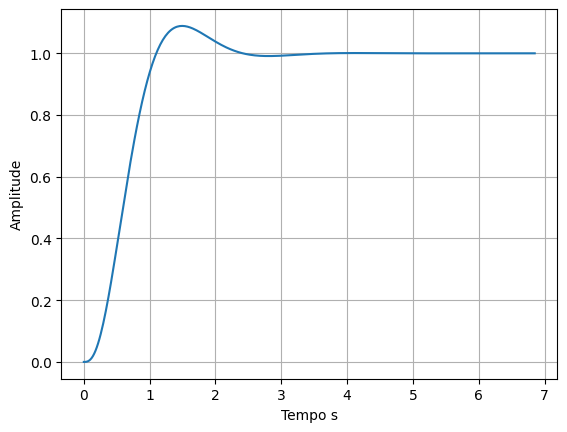

In [61]:

plt.plot(t, y)
np.max(y)
plt.xlabel("Tempo s")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

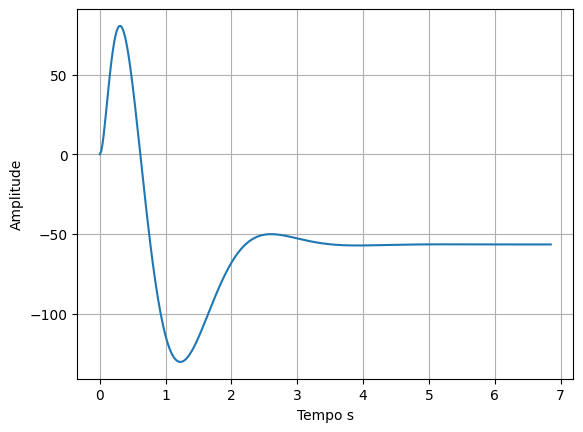

In [62]:
np.max(y)
plt.plot(t,u)
plt.xlabel("Tempo s")
plt.ylabel("Amplitude")
plt.grid()
plt.show()